In [ ]:
#%% import packages:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

In [ ]:
#%% check if cuda is available:
if torch.cuda.is_available():
    print('cuda is available')
    device = torch.device("cuda:0")
else:
    print('cuda is not available')
    device = torch.device("cpu")

cuda is not available


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

max_field_width = 53.3  # in yards
max_field_height = 120  # in yards
num_channels = 8  # 2 for position, 3 for player attributes, 3 for ball attributes

class NFLDataset(Dataset):
    def __init__(self, csv_file, grid_size=(100, 100), transform=None):
        self.nfl_data = pd.read_csv(csv_file)
        self.grid_size = grid_size
        self.transform = transform

    def __len__(self):
        return len(self.nfl_data)

    def __getitem__(self, idx):
        data_row = self.nfl_data.iloc[idx]

        # Initialize a grid with multiple channels
        grid = np.zeros((num_channels, *self.grid_size))

        # Center of the grid
        center_x, center_y = self.grid_size[0] // 2, self.grid_size[1] // 2

        # Normalize and translate player and ball positions
        ball_x, ball_y = data_row['ball_x'], data_row['ball_y']
        player_x, player_y = data_row['player_x'], data_row['player_y']

        # Normalize positions
        norm_player_x = int((player_x - ball_x) / max_field_width * self.grid_size[0]) + center_x
        norm_player_y = int((player_y - ball_y) / max_field_height * self.grid_size[1]) + center_y

        # Place player and ball in their respective position layers
        if 0 <= norm_player_x < self.grid_size[0] and 0 <= norm_player_y < self.grid_size[1]:
            grid[0, norm_player_x, norm_player_y] = 1  # Player position layer
        grid[1, center_x, center_y] = 1  # Ball position layer (always at the center)

        # Populate other attribute layers (speed, acceleration, direction) for player and ball
        # Normalize these attributes as needed
        grid[2, norm_player_x, norm_player_y] = data_row['player_s']  # Player speed
        grid[3, norm_player_x, norm_player_y] = data_row['player_a']  # Player acceleration
        grid[4, norm_player_x, norm_player_y] = data_row['player_dir']  # Player direction
        grid[5, center_x, center_y] = data_row['ball_s']  # Ball speed
        grid[6, center_x, center_y] = data_row['ball_a']  # Ball acceleration
        grid[7, center_x, center_y] = data_row['ball_dir']  # Ball direction

        grid_tensor = torch.tensor(grid, dtype=torch.float32)

        label = data_row['tackle']

        if self.transform:
            grid_tensor = self.transform(grid_tensor)

        return grid_tensor, label

# Usage example
nfl_dataset = NFLDataset(csv_file='data/extended_tackles_with_tracking_test_batch_200.csv', grid_size=(100, 100))

# Create a DataLoader
dataloader = DataLoader(nfl_dataset, batch_size=4, shuffle=True)

# Example of iterating over the DataLoader
for grid, label in dataloader:
    print(grid.shape, label)
    break  # Remove this to iterate over the entire dataset


torch.Size([4, 8, 100, 100]) tensor([1., 1., 1., 1.], dtype=torch.float64)


Label: 1.0


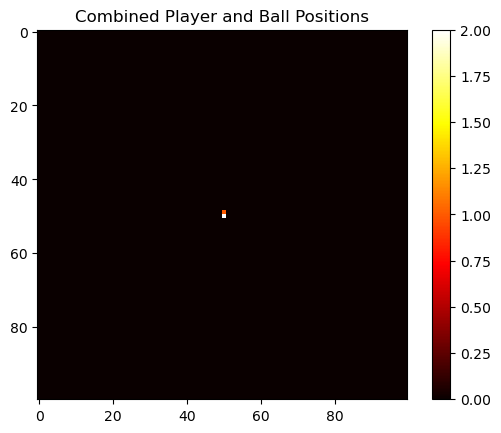

In [ ]:
def visualize_grid(grid):
    # Create a combined grid for visualization
    # Assuming channel 0 is player position and channel 1 is ball position
    combined_grid = np.zeros_like(grid[0])
    combined_grid[grid[0] == 1] = 1  # Mark player positions
    combined_grid[grid[1] == 1] = 2  # Mark ball positions

    # Visualize the combined grid
    plt.imshow(combined_grid, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Combined Player and Ball Positions')
    plt.show()

# Usage example
nfl_dataset = NFLDataset(csv_file='data/extended_tackles_with_tracking_test_batch_200.csv', grid_size=(100, 100))

# Test the visualization
for i in range(3,4):  # Visualize the first 3 examples
    grid, label = nfl_dataset[i]
    print(f"Label: {label}")
    visualize_grid(grid.numpy())


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(16 * 50 * 50, 128)  # Adjust the input features
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = x.view(-1, 16 * 50 * 50)  # Flatten the output for the fully connected layer
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x



In [ ]:
model = SimpleCNN()
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def calculate_accuracy(loader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [ ]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader
nfl_dataset_big = NFLDataset(csv_file='data/extended_tackles_with_tracking.csv', grid_size=(100, 100))
nfl_dataset = NFLDataset(csv_file='data/extended_tackles_with_tracking_test_batch_200.csv', grid_size=(100, 100))

# Define the proportions
total_size = len(nfl_dataset)  # Use the nfl_dataset instance you already created
train_size = int(total_size * 0.7)  # 70% of data
val_size = int(total_size * 0.2)  # 20% of data
test_size = total_size - train_size - val_size  # Remaining 10% for testing

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(nfl_dataset, [train_size, val_size, test_size])

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [ ]:
num_epochs =   # Define the number of epochs

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = torch.squeeze(outputs)  # Squeeze the output to match label's shape
        loss = loss_function(outputs, labels.float())  # Ensure labels are float type
        loss.backward()
        optimizer.step()

    # Calculate training accuracy
    train_accuracy = calculate_accuracy(train_loader, model)

    # Switch model to evaluation mode for validation accuracy
    model.eval()
    val_accuracy = calculate_accuracy(val_loader, model)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Accuracy: {train_accuracy:.2f}, Validation Accuracy: {val_accuracy:.2f}')


Epoch 1/20, Training Accuracy: 4.00, Validation Accuracy: 4.00
Epoch 2/20, Training Accuracy: 4.00, Validation Accuracy: 4.00
Epoch 3/20, Training Accuracy: 4.00, Validation Accuracy: 4.00
Epoch 4/20, Training Accuracy: 4.00, Validation Accuracy: 4.00
Epoch 5/20, Training Accuracy: 4.00, Validation Accuracy: 4.00
Epoch 6/20, Training Accuracy: 4.00, Validation Accuracy: 4.00
Epoch 7/20, Training Accuracy: 4.00, Validation Accuracy: 4.00
Epoch 8/20, Training Accuracy: 4.00, Validation Accuracy: 4.00
Epoch 9/20, Training Accuracy: 4.00, Validation Accuracy: 4.00
Epoch 10/20, Training Accuracy: 4.00, Validation Accuracy: 4.00
Epoch 11/20, Training Accuracy: 4.00, Validation Accuracy: 4.00
Epoch 12/20, Training Accuracy: 4.00, Validation Accuracy: 4.00
Epoch 13/20, Training Accuracy: 4.00, Validation Accuracy: 4.00


KeyboardInterrupt: 